In [1]:
import numpy as np

# ==============================================================================
# SIMULACIÓN DEL MODELO DE ISING
# ==============================================================================
# Parámetros
N = 64                  # Tamaño de la red (N x N)
T = 2.269               # Temperatura (usar T = 1.5, 2.269, 3.5 para comparar)
MC_STEPS = 500          # Total de pasos Monte Carlo
SAVE_INTERVAL = 1       # Guardar cada X pasos (1 = todos los pasos)

# Inicialización de la red
spins = np.random.choice([-1, 1], size=(N, N))

# Abrir archivo para guardar datos
with open("ising_data.dat", "w") as file:
    for step in range(MC_STEPS):
        # Paso Monte Carlo (N² intentos de volteo)
        for _ in range(N*N):
            # Seleccionar espín aleatorio
            i, j = np.random.randint(0, N, 2)
            
            # Calcular energía con condiciones periódicas
            vecinos = (
                spins[(i+1)%N, j] + spins[(i-1)%N, j] +
                spins[i, (j+1)%N] + spins[i, (j-1)%N]
            )
            delta_E = 2 * spins[i, j] * vecinos
            
            # Criterio de Metropolis
            if delta_E <= 0 or np.random.rand() < np.exp(-delta_E/T):
                spins[i, j] *= -1

        # Guardar configuración cada SAVE_INTERVAL pasos
        if step % SAVE_INTERVAL == 0:
            np.savetxt(file, spins, fmt="%d", delimiter=",")
            file.write("\n")  # Separador entre instantes

# Mensaje final
print(f"Simulación completada. Datos guardados en 'ising_data.dat'")
print(f"Configuraciones guardadas: {MC_STEPS//SAVE_INTERVAL}")

Simulación completada. Datos guardados en 'ising_data.dat'
Configuraciones guardadas: 500


C:\Users\garci\AppData\Local\Temp\ipykernel_18424\1353426835.py:74: UserWarning: loadtxt: input contained no data: "<_io.StringIO object at 0x0000026EA7CB6A40>"
  frame_data = np.loadtxt(io.StringIO(frame_data_str), delimiter=",")


TypeError: Invalid shape (0,) for image data

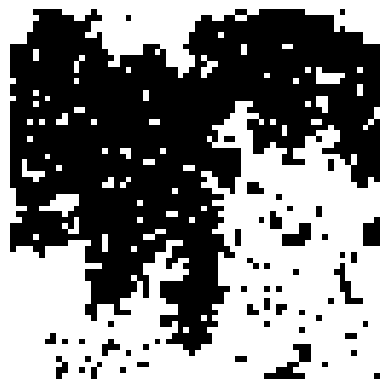

In [5]:
# ================================================================================
# ANIMACION ISING
#
# CURSO 2023-2024
# contenido
# Genera una animación a partir de un fichero de datos con la configuración
# del retículo en cada instante de tiempo
# 
# El fichero debe estructurarse de la siguiente forma:
# 
#   s(1,1)_1, s(1,2)_1, ..., s(1,M)_1
#   s(2,1)_1, s(2,2)_1, ..., s(2,M)_1
#   (...)
#   s(N,1)_1, s(N,2)_1, ..., s(N,M)_1
#   
#   s(1,1)_2, s(1,2)_2, ..., s(1,M)_2
#   s(2,1)_2, s(2,2)_2, ..., s(2,M)_2
#   (...)
#   s(N,1)_2, s(N,2)_2, ..., s(N,M)_2
#
#   s(1,1)_3, s(1,2)_3, ..., s(1,M)_3
#   s(2,1)_3, s(2,2)_3, ..., s(2,M)_3
#   (...)
#   s(N,1)_3, s(N,2)_3, ..., s(N,M)_3
#   
#   (...)
#
# donde s(i,j)_k es el valor del spin en la fila i-ésima y la columna
# j-ésima en el instante k. M es el número de columnas y N el número
# de filas en el retículo. Los valores del spin deben ser +1 ó -1.
# El programa asume que las dimensiones del retículo no cambian a lo
# largo del tiempo.
# 
# Si solo se especifica un instante de tiempo, se genera una imagen en pdf
# en lugar de una animación
#
# Se puede configurar la animación cambiando el valor de las variables
# de la sección "Parámetros"
#
# ================================================================================

# Importa los módulos necesarios
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import io

# Parámetros
# ========================================
file_in = "ising_data.dat" # Nombre del fichero de datos
file_out = "ising" # Nombre del fichero de salida (sin extensión)
interval = 100 # Tiempo entre fotogramas en milisegundos
save_to_file = True # False: muestra la animación por pantalla,
                     # True: la guarda en un fichero
dpi = 500 # Calidad del vídeo de salida (dots per inch)


# Lectura del fichero de datos
# ========================================
# Lee el fichero a una cadena de texto
with open(file_in, "r") as f:
    data_str = f.read()

# Inicializa la lista con los datos de cada fotograma.
# frames_data[j] contiene los datos del fotograma j-ésimo
frames_data = list()

# Itera sobre los bloques de texto separados por líneas vacías
# (cada bloque corresponde a un instante de tiempo)
for frame_data_str in data_str.split("\n\n"):
    # Almacena el bloque en una matriz
    # (io.StringIO permite leer una cadena de texto como si fuera un
    # fichero, lo que nos permite usar la función loadtxt de numpy)
    frame_data = np.loadtxt(io.StringIO(frame_data_str), delimiter=",")

    # Añade los datos del fotograma (la configuración del sistema)
    # a la lista
    frames_data.append(frame_data)

# Creación de la animación/gráfico
# ========================================
# Crea los objetos figure y axis
fig, ax = plt.subplots()

# Define el rango de los ejes
ax.axis("off")  # No muestra los ejes

# Representa el primer fotograma
im = ax.imshow(frames_data[0], cmap="binary", vmin=-1, vmax=+1)
 
# Función que actualiza la configuración del sistema en la animación
def update(j_frame, frames_data, im):
    # Actualiza el gráfico con la configuración del sistema
    im.set_data(frames_data[j_frame])

    return im,

# Calcula el nº de frtogramas o instantes de tiempo
nframes = len(frames_data)

# Si hay más de un instante de tiempo, genera la animación
if nframes > 1:
    animation = FuncAnimation(
            fig, update,
            fargs=(frames_data, im), frames=len(frames_data), blit=True, interval=interval)

    # Muestra por pantalla o guarda según parámetros
    if save_to_file:
        animation.save("{}.mp4".format(file_out), dpi=dpi)
    else:
        plt.show()
# En caso contrario, muestra o guarda una imagen
else:
    # Muestra por pantalla o guarda según parámetros
    if save_to_file:
        fig.savefig("{}.pdf".format(file_out))
    else:
        plt.show()